# Stock Price Forecasting with Long Short-Term Memory (LSTM) Networks

##Importing Necessary Libraries

In [115]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [116]:
#tesla data
ticker = 'TSLA'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


## Load Data

In [117]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


##Shape of Data

In [118]:
data.shape

(3400, 6)

In [119]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3.400000e+03
mean,70.493993,72.048393,68.819973,70.474242,70.474242,9.681167e+07
std,101.559061,103.824949,99.066386,101.480831,101.480831,8.004848e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,10.722500,11.014167,10.417333,10.779833,10.779833,4.598775e+07
50%,16.944000,17.218667,16.679334,16.928666,16.928666,8.122500e+07
75%,109.584000,111.962500,104.220999,108.349998,108.349998,1.235249e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


## Checking for missing values

In [120]:
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3400 entries, 2010-06-29 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3400 non-null   float64
 1   High       3400 non-null   float64
 2   Low        3400 non-null   float64
 3   Close      3400 non-null   float64
 4   Adj Close  3400 non-null   float64
 5   Volume     3400 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.9 KB


##Exploratory Data Analysis (EDA)

##Univariate Analysis

In [122]:
def plot_graph(figsize, values, column_name):
    plt.figure(figsize=figsize)
    plt.title(f"{column_name} Price History")
    plt.plot(values)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel(f"{column_name} Price USD ($)", fontsize=18)
    plt.show()

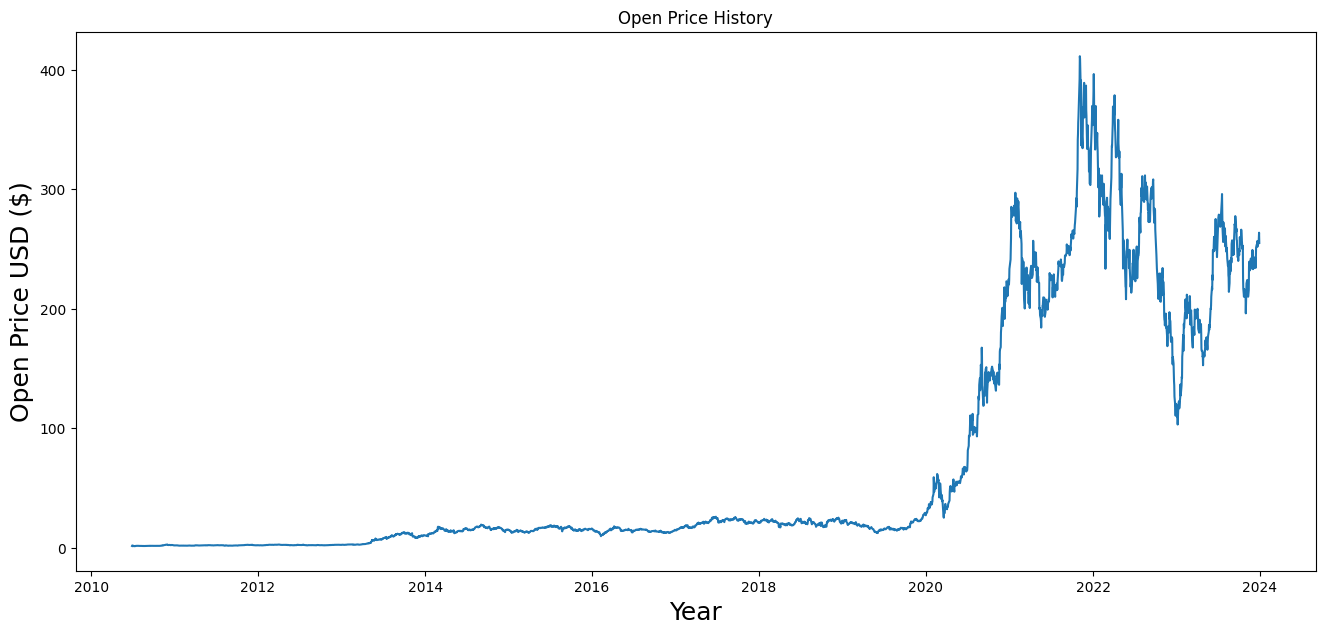

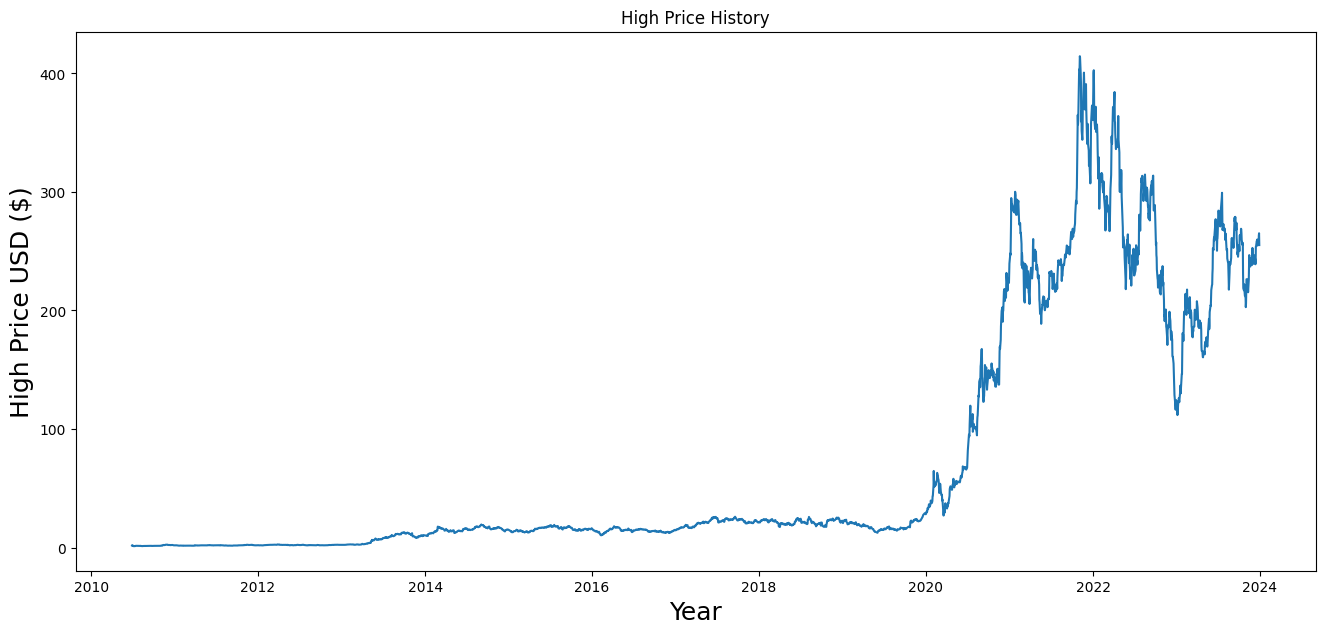

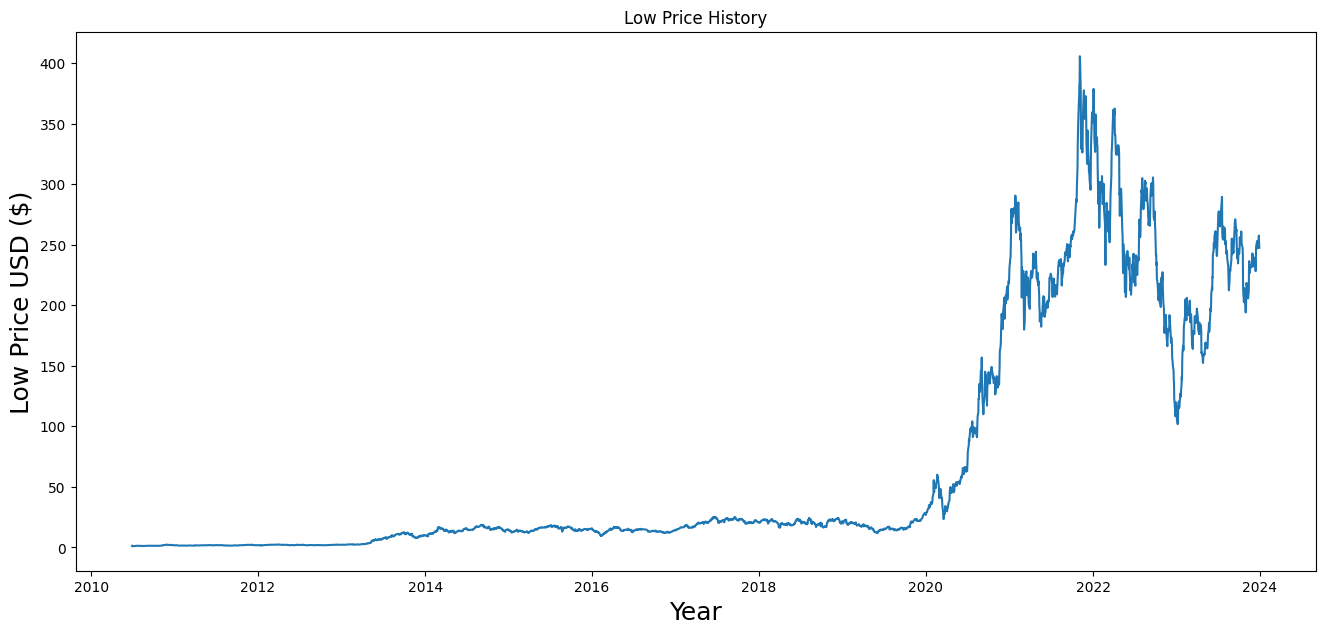

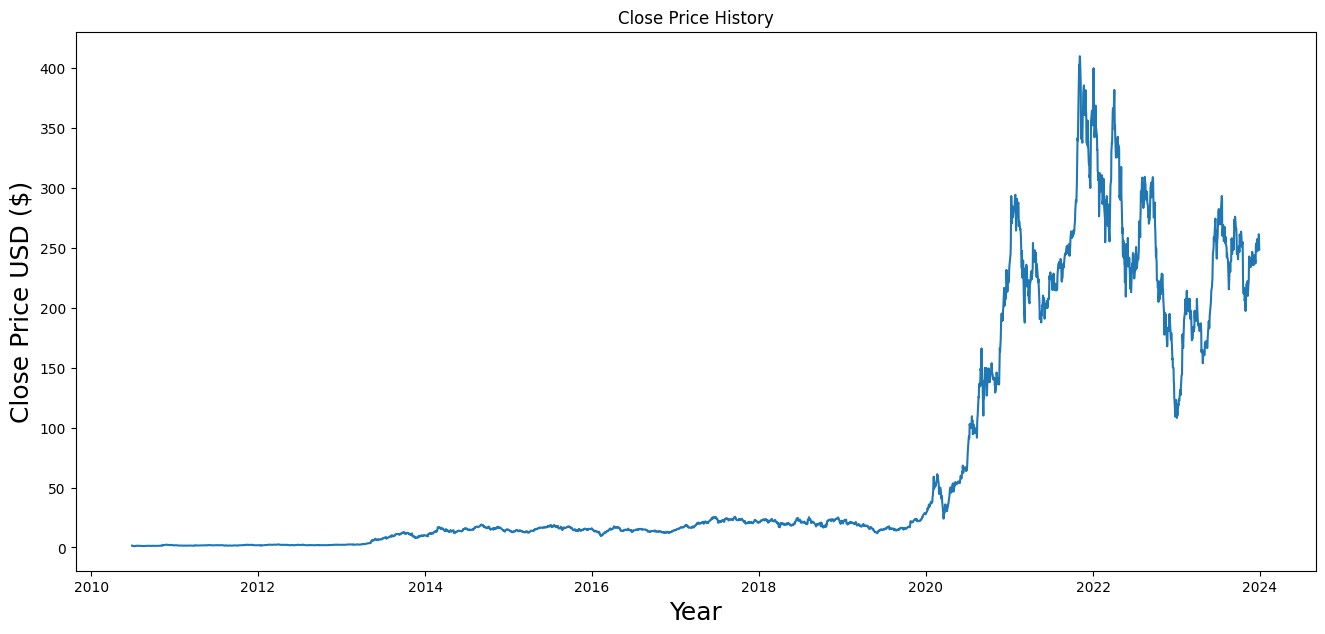

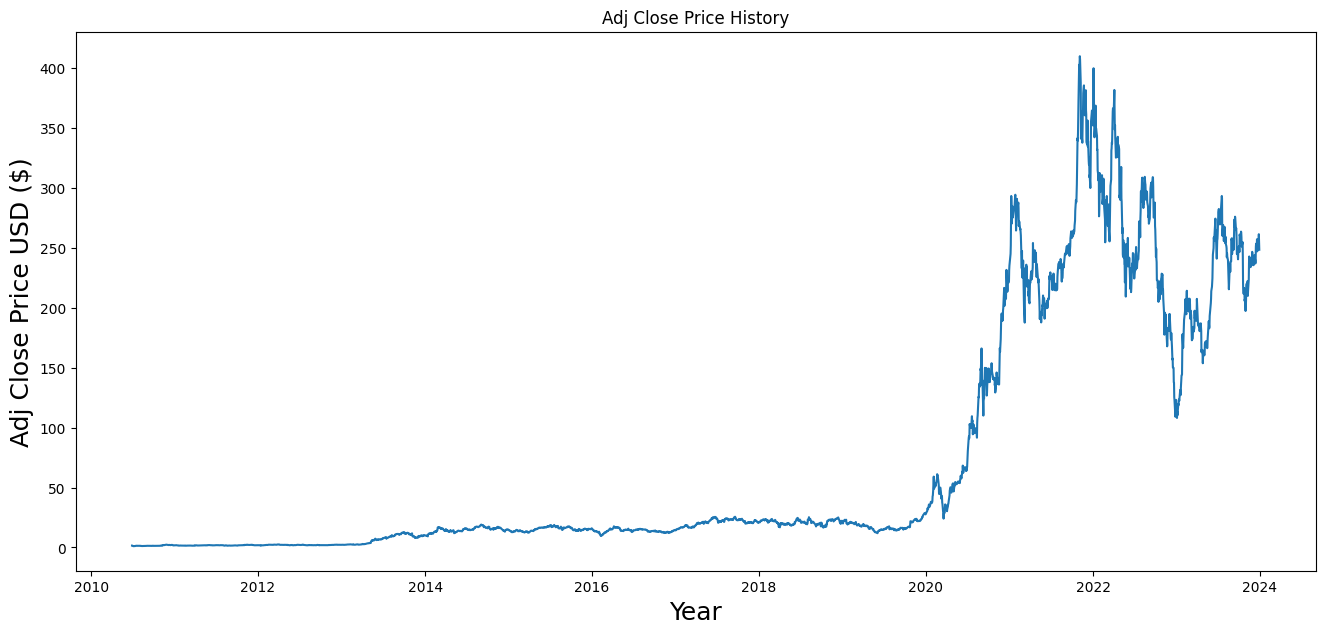

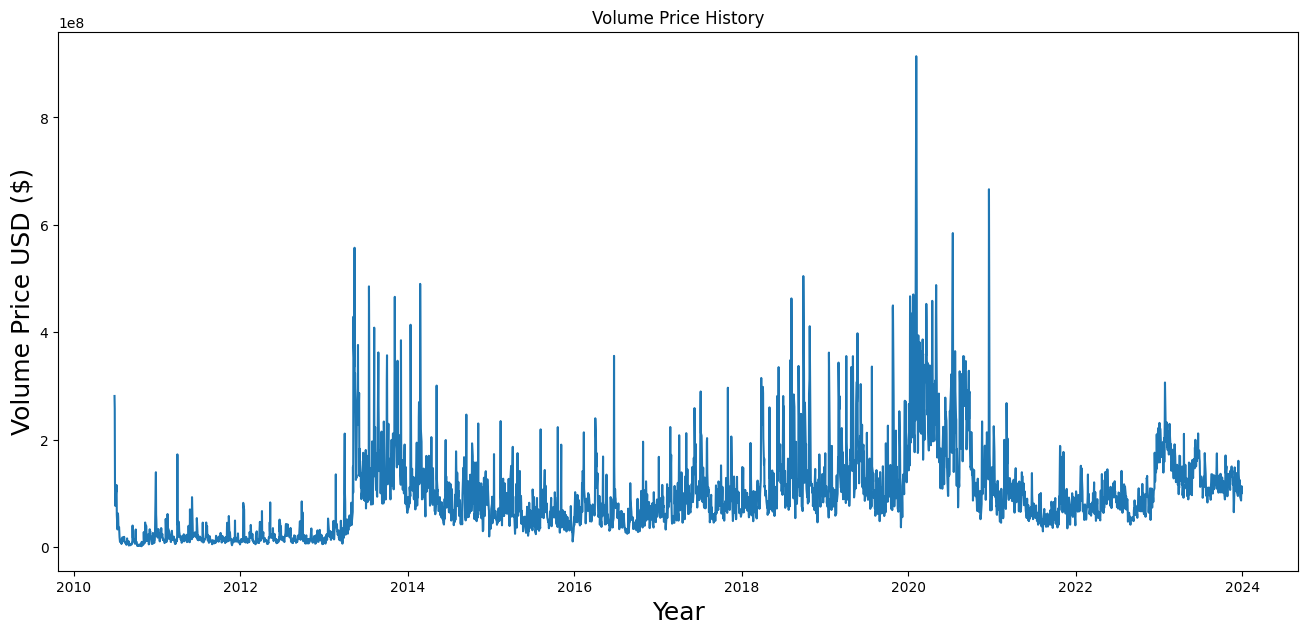

In [123]:
for column in data.columns:
    plot_graph((16,7), data[column], column)

#Plotting Moving Averages

##Simple Moving Average (SMA)

####The SMA is calculated by averaging the closing prices over a specified window of days (e.g., 20 days). It is useful for identifying trends and smoothing out short-term fluctuations.

In [124]:
def calculate_sma(data, window):
  return data['Adj Close'].rolling(window=window).mean()

In [125]:
##Calculate SMA for 100 Days
data['SMA_100'] = calculate_sma(data, window=100)

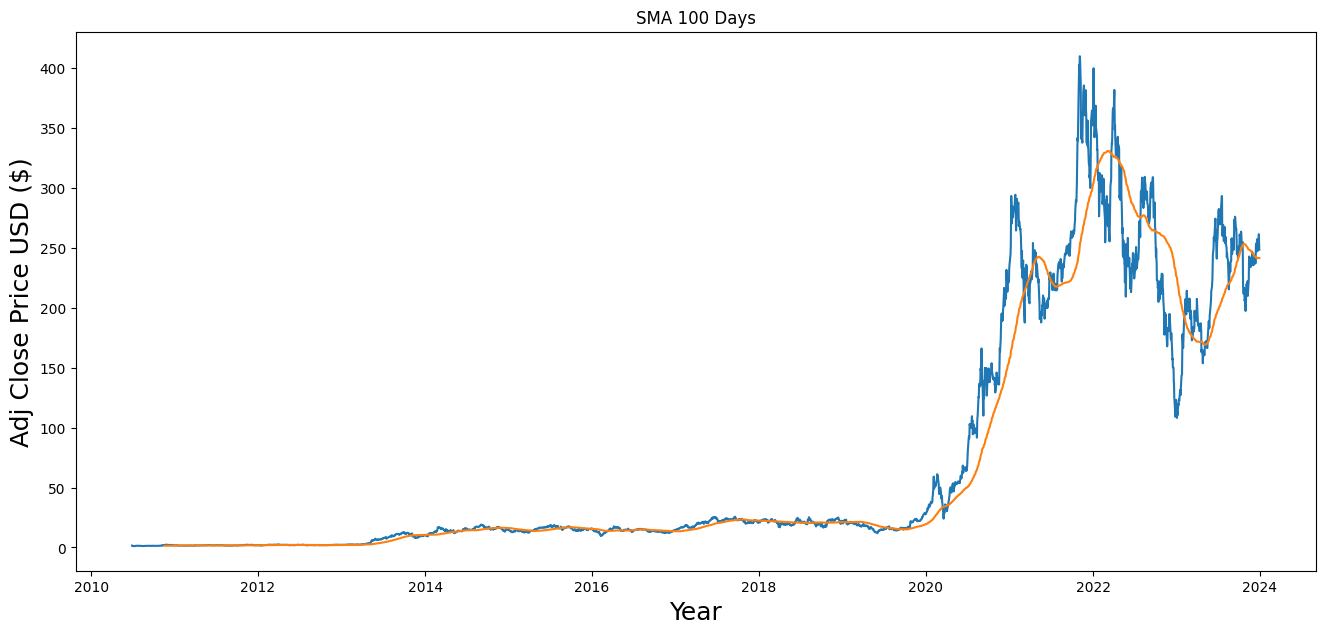

In [126]:
plt.figure(figsize=(16,7))
plt.title('SMA 100 Days')
plt.plot(data['Close'])
plt.plot(data['SMA_100'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Adj Close Price USD ($)', fontsize=18)
plt.show()

In [127]:
data['SMA_20'] = calculate_sma(data, window=20)

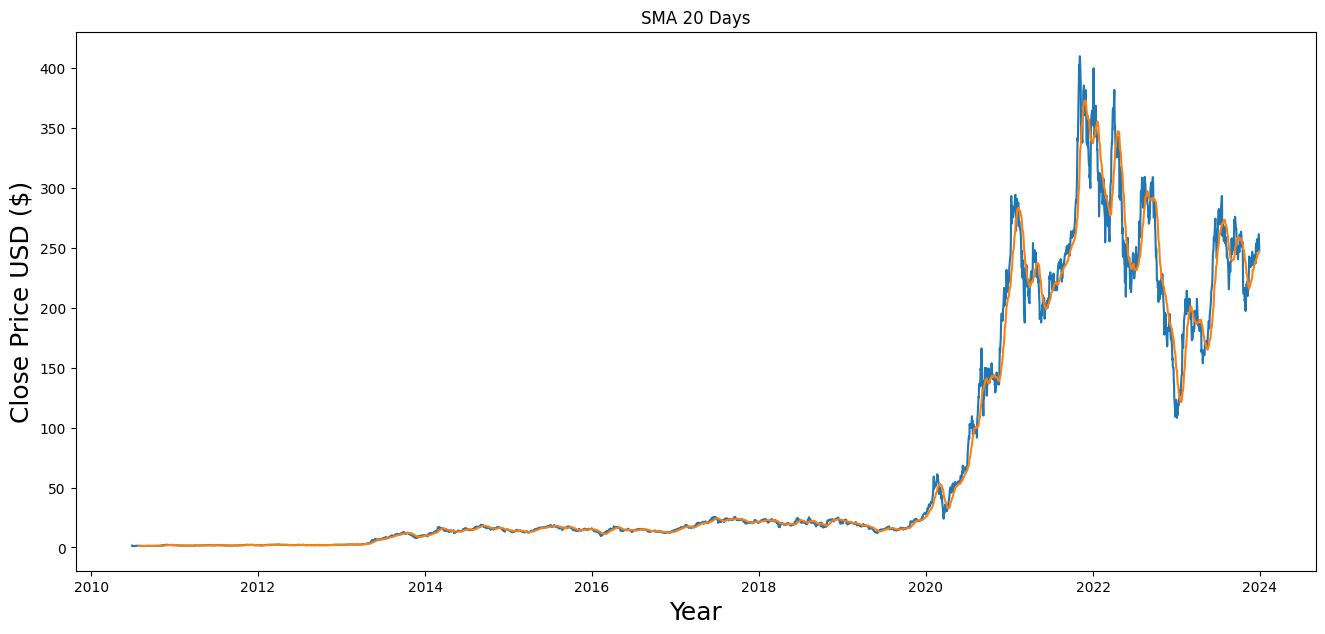

In [128]:
plt.figure(figsize=(16,7))
plt.title('SMA 20 Days')
plt.plot(data['Adj Close'])
plt.plot(data['SMA_20'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

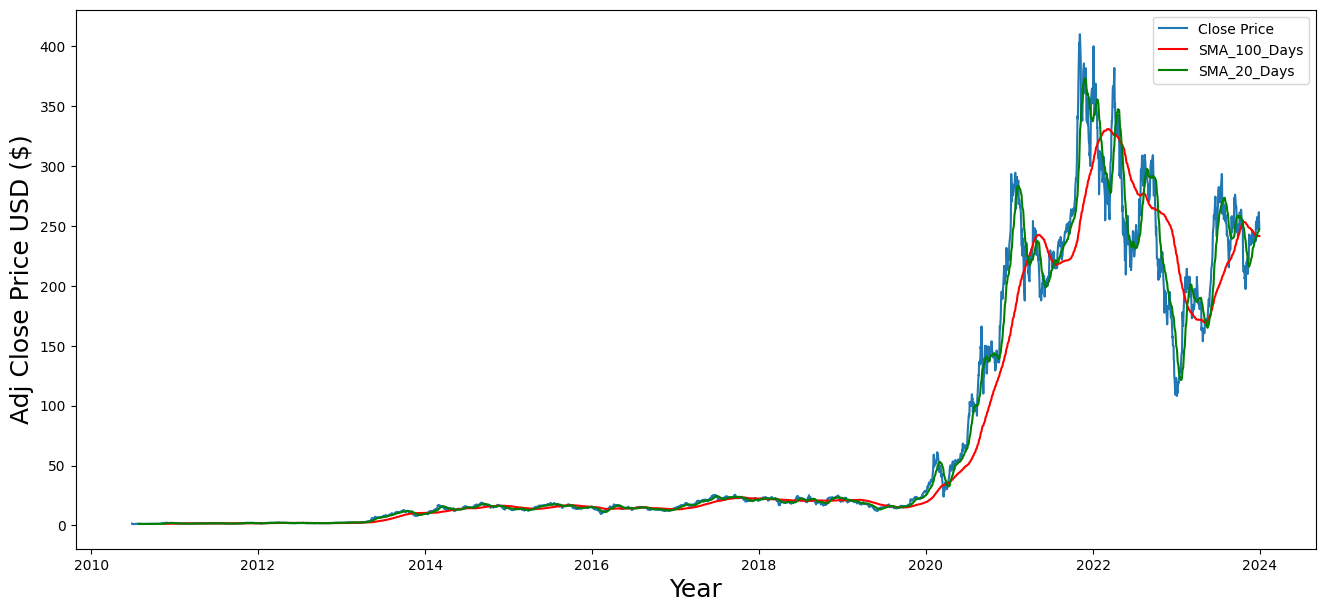

In [129]:
#lets compare all three sma
plt.figure(figsize=(16,7))
plt.plot(data['Close'], label ='Close Price' )
plt.plot(data['SMA_100'], label = 'SMA_100_Days', color = 'red')
plt.plot(data['SMA_20'], label = 'SMA_20_Days', color='green')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Adj Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

#Exponential Moving Average (EMA)

#### The EMA gives more prefeces to the recent points, which makes it more responsive to the recent Price change than SMA

In [130]:
def calculate_ema(data, window):
  return data['Adj Close'].ewm(span=window, adjust=False).mean()

In [131]:
data['EMA_20'] = calculate_ema(data, window=20)

In [132]:
data['EMA_20']

,EMA_20
Date,
2010-06-29,1.592667
2010-06-30,1.592286
2010-07-01,1.580068
2010-07-02,1.551490
2010-07-06,1.506015
...,...
2023-12-22,244.955352
2023-12-26,246.065317
2023-12-27,247.529573


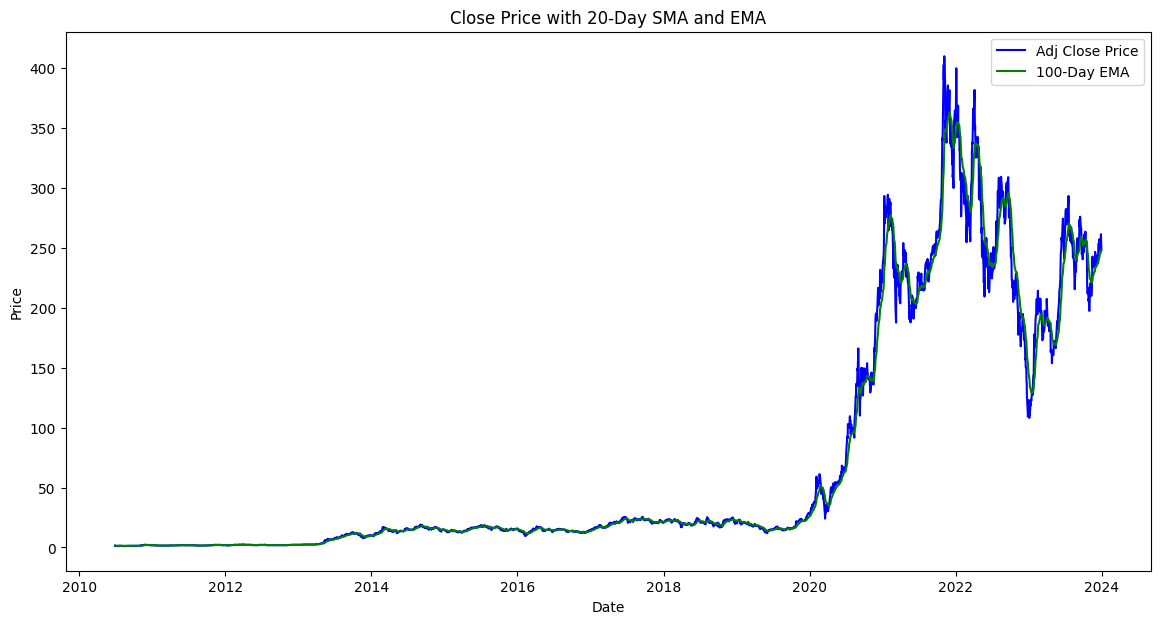

In [133]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Adj Close Price', color='blue')
plt.plot(data['EMA_20'], label='100-Day EMA', color='green')
plt.title('Close Price with 20-Day SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### EMA is giving better results than SMA

#Daily Perecentage Change

####This shows the daily percentage change in the stock prices.





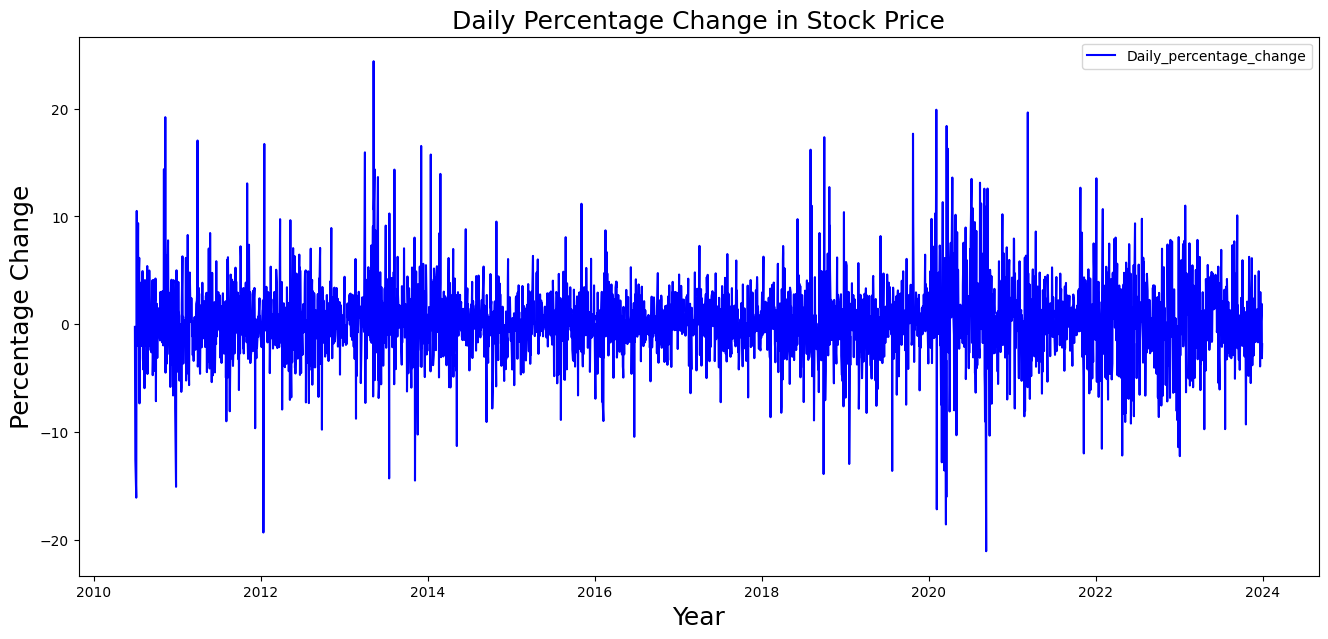

In [134]:
data['Daily_Pct_Change'] = data['Adj Close'].pct_change()*100

#plot Daily Percentage Change
plt.figure(figsize=(16,7))
plt.title('Daily Percentage Change in Stock Price', fontsize=18)
plt.plot(data['Daily_Pct_Change'], label = "Daily_percentage_change", color ='blue')
plt.xlabel('Year', fontsize=18)
plt.legend()
plt.ylabel('Percentage Change', fontsize=18)
plt.show()

#Cumulative Percentage Change

####Calculated by comparing the current closing price to the initial closing price.


In [135]:
data['Cumulative_Pct_Change'] = (data['Adj Close']/data['Adj Close'].iloc[0]-1)*100

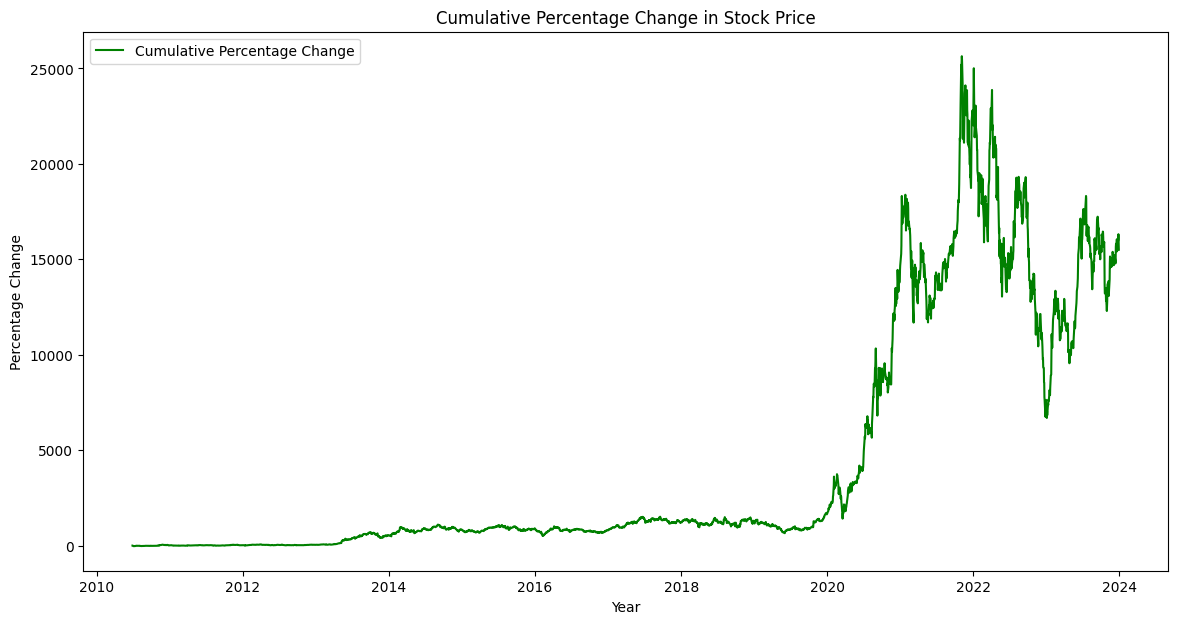

In [136]:
# Plot Cumulative Percentage Change
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative_Pct_Change'], label='Cumulative Percentage Change', color='green')
plt.title('Cumulative Percentage Change in Stock Price')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

#Normalizing the Data

In [137]:
Adj_close_price = data[['Adj Close']]

In [138]:
Adj_close_price.head()

,Adj Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [139]:
Adj_close_price.shape

(3400, 1)

In [140]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(Adj_close_price)

In [141]:
len(scaled_data)

3400

In [142]:
x_data = []
y_data = []

In [143]:
for i in range(20, len(scaled_data)):
  x_data.append(scaled_data[i-20:i])
  y_data.append(scaled_data[i])

x_data = np.array(x_data)
y_data = np.array(y_data)


In [144]:
x_data[0], y_data[0]

(array([[1.31893362e-03],
        [1.30915180e-03],
        [1.00428027e-03],
        [5.54310805e-04],
        [5.05407544e-05],
        [0.00000000e+00],
        [2.70634579e-04],
        [2.60852469e-04],
        [2.03792057e-04],
        [3.81495574e-04],
        [6.58652434e-04],
        [6.66803171e-04],
        [7.89077648e-04],
        [9.96129534e-04],
        [7.33645693e-04],
        [7.20604046e-04],
        [8.47769140e-04],
        [8.95047734e-04],
        [8.39618402e-04],
        [7.74404629e-04]]),
 array([0.00080212]))

#Splitting the Dataset into trainig and Testing Data

In [145]:
split = int(len(x_data)*0.7)
x_train = x_data[:split]
y_train = y_data[:split]
x_test = x_data[split:]
y_test = y_data[split:]

In [146]:
#print shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2366, 20, 1)
(2366, 1)
(1014, 20, 1)
(1014, 1)


In [147]:
model1 = Sequential()
model1.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
model1.compile(optimizer='adam', loss='mean_squared_error')

In [149]:
model1.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7093e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4494e-06
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2017e-06
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7823e-06
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8159e-06
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2126e-06
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0102e-06
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3254e-06
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5730e-06
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6084e-06
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8878e-06
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0472e-06
Epoch 13/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0721e-06
Epoch 14/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6395e-06
Epoch 15/50
74/74 ━━━━━━━━━━━

In [150]:
predictions = model1.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [151]:
predictions

array([[0.06031398],
       [0.06207779],
       [0.06285789],
       ...,
       [0.60312325],
       [0.6139347 ],
       [0.60584337]], dtype=float32)

#Model Evaluation

In [152]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[ 25.716724],
       [ 26.437977],
       [ 26.756971],
       ...,
       [247.6805  ],
       [252.10147 ],
       [248.79279 ]], dtype=float32)

In [153]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[ 26.93600082],
       [ 27.03933334],
       [ 27.94799995],
       ...,
       [261.44000244],
       [253.17999268],
       [248.47999573]])

In [154]:
rmse = np.sqrt(np.mean( (inv_predictions - inv_y_test)**2))

In [155]:
rmse

11.096512744218252

In [156]:
ploting_data = pd.DataFrame(
 {
  'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
 } ,
    index = data.index[split+20:]
)
ploting_data.head()

,original_test_data,predictions
Date,,
2019-12-19,26.936001,25.716724
2019-12-20,27.039333,26.437977
2019-12-23,27.948000,26.756971
2019-12-24,28.350000,27.381702
2019-12-26,28.729334,27.889484


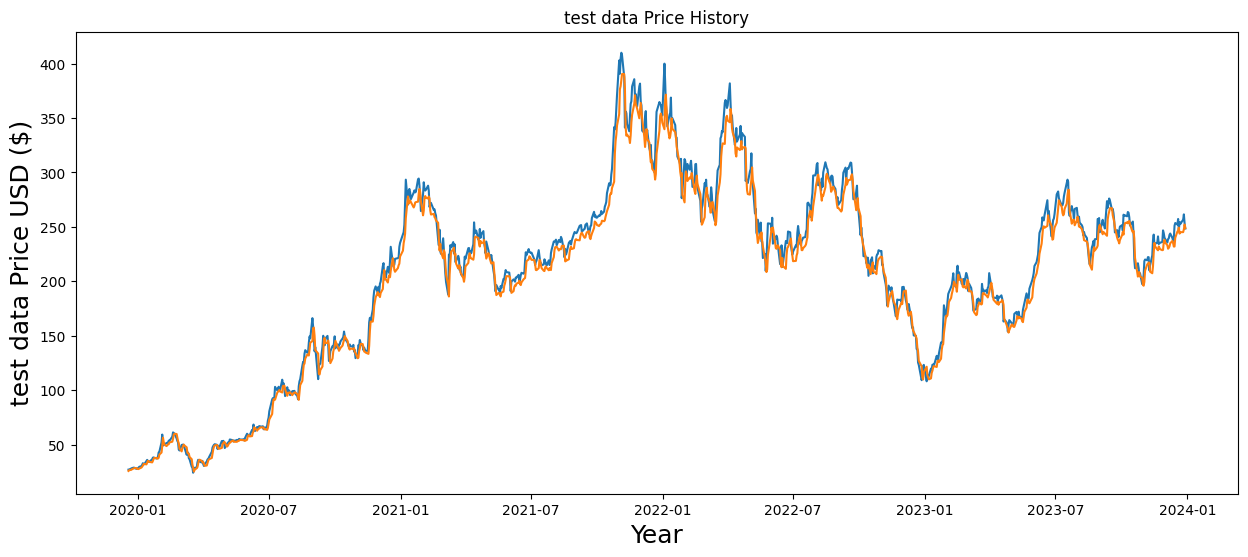

In [157]:
plot_graph((15,6), ploting_data, 'test data')

In [158]:
# Evaluate the model on the test set
test_loss = model1.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2893e-04
Test Loss: 0.0007363828481175005


In [160]:
# Generate predictions on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(x_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.024737094827548406
Root Mean Squared Error (RMSE): 0.15728030654709574
Mean Absolute Error (MAE): 0.13227531107149018
